In [1]:
import wfdb
from wfdb import processing
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
from scipy import signal
import math
import seaborn as sns

In [2]:
def load_data(path):
    """Loads database file and returns ECG signal samples and fields list"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:,0]
        ecg = ecg.flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def estimate_threshold(signal, perc=92):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Removes the baseline wander for better manipulation with data. Using Fourier Transformation
    to locate lowfrequency components and erasing them."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1/sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline


def find_Rpeaks(signal):
    """Finds R peaks in ECG signal with dynamically changing window size.
    Returns a list of peaks and corresponding times."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def preprocess_signals(signals, samp_rates):
    dominant_samp_rate = samp_rates[np.argmax(samp_rates)]

    synchronized_signals = []

    #resampling
    for i, (signal, samp_rate) in enumerate(zip(signals, samp_rates)):
        if samp_rate != dominant_samp_rate:
            isignal = scipy.signal.resample(signal, int(signal.size * (dominant_samp_rate / samp_rate)))
            signals[i] = isignal[:signal.size]

    #start from peak
    for i, (signal, samp_rate) in enumerate(zip(signals, samp_rates)):
        R_peaks_positions = find_Rpeaks(signal[:int(samp_rate)*2])
        if not R_peaks_positions.any():
            imax = np.argmax(signal[:int(samp_rate)*2])
            synchronized_signals.append(signal[imax:])
        else:
            synchronized_signal = signal[R_peaks_positions[0]:]
            synchronized_signals.append(synchronized_signal)

    #cropping to same length
    min_length = min([signal.size for signal in synchronized_signals])

    for i, (signal, size) in enumerate(zip(synchronized_signals, [s.size for s in synchronized_signals])):
        if size != min_length:
            synchronized_signals[i] = signal[:min_length]

    return synchronized_signals

In [44]:
database = ["Database/drive{:02d}".format(i+1) for i in range(16)] + ["Database/drive17a", "Database/drive17b"]
signals = []
samps = []

size = 13

for i in range(1, size):
    ecg, fields = load_data(database[i])
    samp_rate = fields['fs']

    signals.append(remove_baseline_wander_fft(ecg, samp_rate))
    samps.append(samp_rate)

dominant_samp = samps[np.argmax(samps)]

<built-in function min>


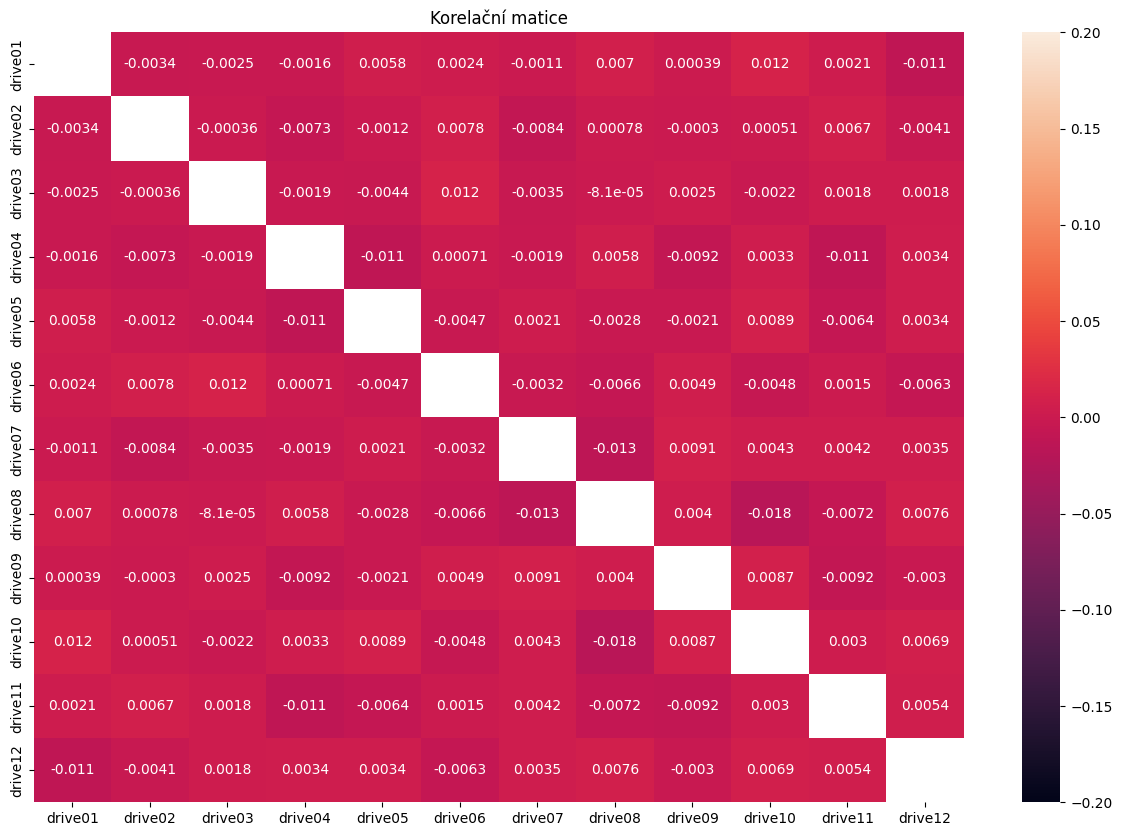

In [45]:
final_signals= preprocess_signals(signals, samps)

data_as_list = [np.array(sublist) for sublist in final_signals]
data_as_array = np.array(data_as_list)

correlation_matrix = np.corrcoef(data_as_array)
correlation_matrix[np.round(correlation_matrix, 4) == 1] = np.nan

plt.figure(figsize=(15,10))
plt.title("Korelační matice")
sns.heatmap(correlation_matrix, annot=True,
            xticklabels = [item[9:] for item in database[:size-1]],
            yticklabels = [item[9:] for item in database[:size-1]],
            vmin= -0.2, vmax= 0.2)
plt.show()


In [46]:
imin = np.unravel_index(np.nanargmin(abs(correlation_matrix)), correlation_matrix.shape)
imax = np.unravel_index(np.nanargmax(abs(correlation_matrix)), correlation_matrix.shape)

vmin = np.nanmin(abs(correlation_matrix))
vmax = np.nanmax(abs(correlation_matrix))

min_labels = (database[imin[0]], database[imin[1]])
max_labels = (database[imax[0]], database[imax[1]])

print("Lowest value in correlation matrix:", vmin)
print("Corresponding labels:", min_labels)

print("\nHighest value in correlation matrix:", vmax)
print("Corresponding labels:", max_labels)

Lowest value in correlation matrix: 8.087290309805414e-05
Corresponding labels: ('Database/drive03', 'Database/drive08')

Highest value in correlation matrix: 0.017879375345505807
Corresponding labels: ('Database/drive10', 'Database/drive08')


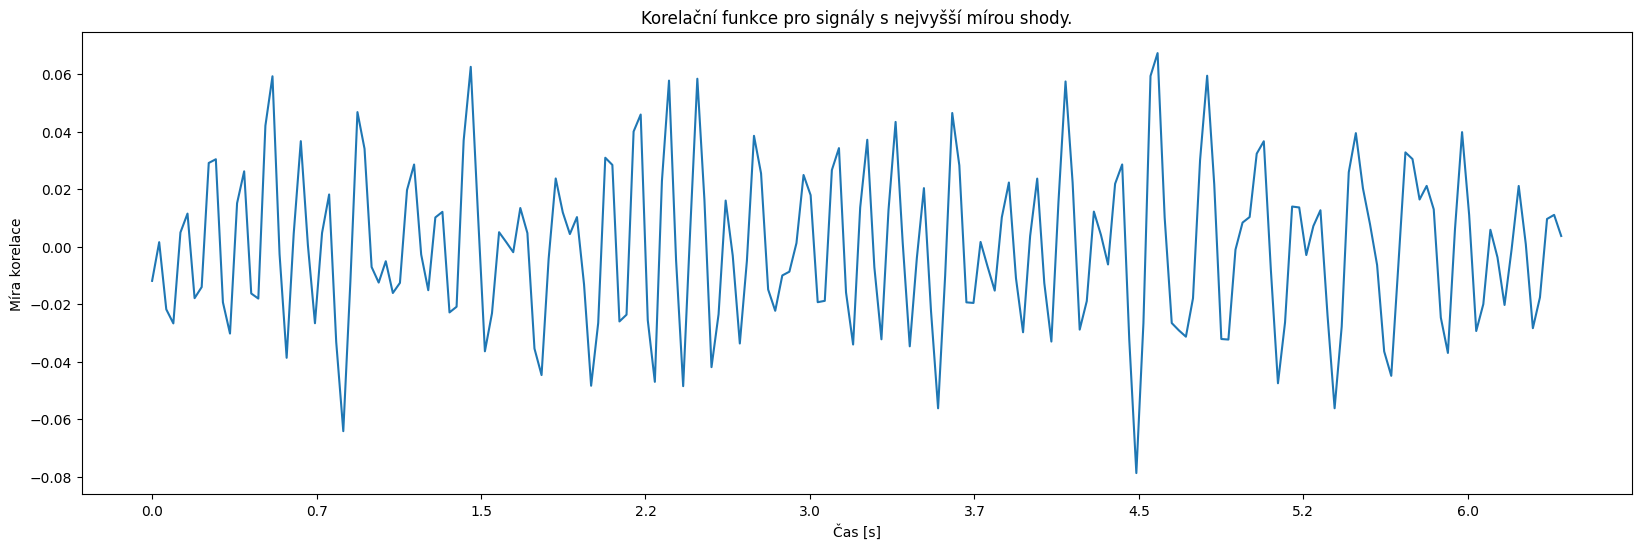

In [50]:
signal1 = data_as_array[imax[0]][:400]
signal2 = data_as_array[imax[1]][:400]

corr_fn = scipy.signal.correlate(signal1, signal2, mode="same")
corr_fn= np.array_split(corr_fn, 2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(signal1)//2, 60*12/dominant_samp), np.round(np.arange(0, len(signal1)//2, 60*12/dominant_samp) / dominant_samp, 1))
plt.show()

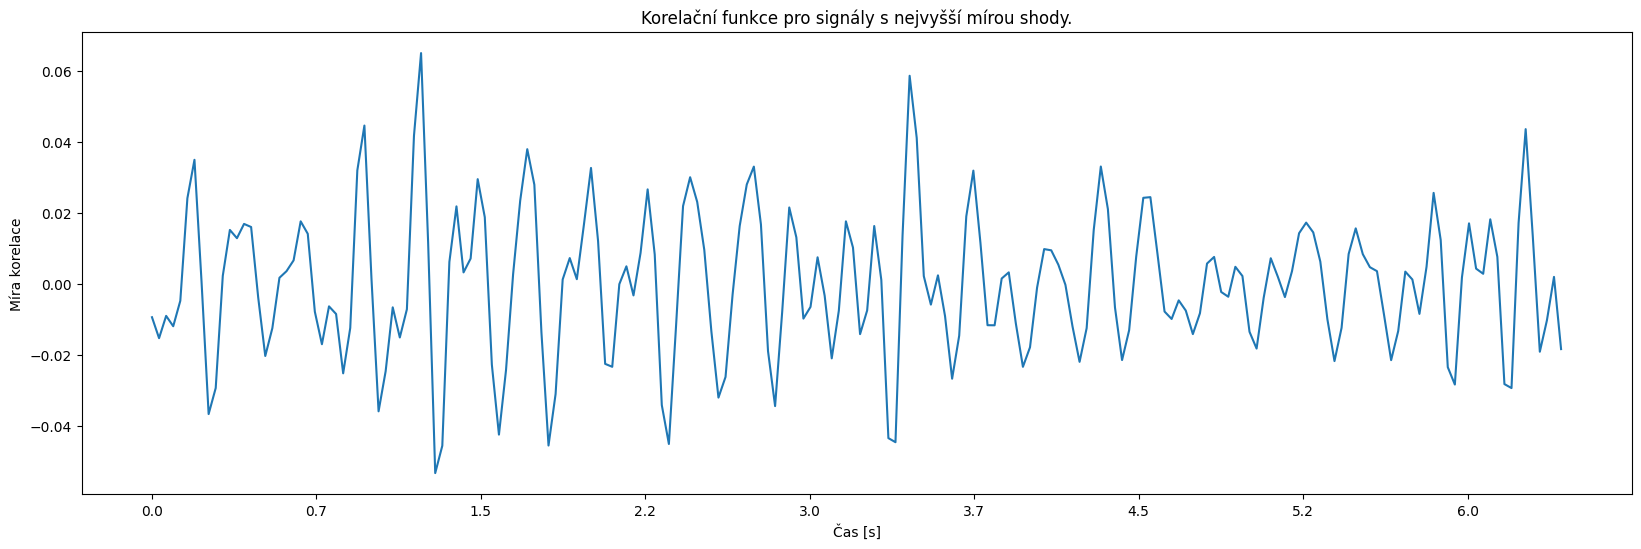

In [53]:
signal1 = data_as_array[imin[0]][:400]
signal2 = data_as_array[imin[1]][:400]

corr_fn = scipy.signal.correlate(signal1, signal2, mode="same")
corr_fn= np.array_split(corr_fn, 2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.xticks(np.arange(0, len(signal1)//2, 60*12/dominant_samp), np.round(np.arange(0, len(signal1)//2, 60*12/dominant_samp) / dominant_samp, 1))
plt.show()